# Uncertainty Quantification


There are always uncertainties in all computational predictions, it could be related to the sparsity of observed instances or the choice of hyperparameters and models. While it is possible to reduce the uncertainties, there is no way to eliminate model uncertainties. Uncertainty quantification is a salient statistical technique to include uncertainty in the model training process so to provide a more accurate and reliable output for users.

With the NeuralProphet default configuration, a single value is predicted for each individual instance. The prediction output is just a point estimator without any consideration on uncertainties. [Prediction interval](https://www.bryanshalloway.com/2021/03/18/intuition-on-uncertainty-of-predictions-introduction-to-prediction-intervals/) instead has provide a more accurate estimation by quantifying the uncertainty and providing you a possible value range for every single individual instance.


In this session, we will be introducing you to the two statistical techniques available in NeuralProphet (1)quantile regression and (2)conformal prediction. These two modules are not mutually exclusive, you may apply both modules on top of any models.

The quantile regression module allows algorithm to learn only a certain quantile of output variables for each instance. As for the conformal prediction module, it adds calibration process on top of the model to quantify uncertainties in data for both point estimators and prediction intervals. You can also find more information about the concept [quantile regression](https://towardsdatascience.com/probabilistic-forecasts-pinball-loss-function-baf86a5a14d0) and [conformal prediction](https://towardsdatascience.com/conformal-prediction-4775e78b47b6) with the attached blogs.

We will illustrate and further elaborate on both quantification modules using the hospital electric load dataset. The dataset has recorded the electricity consumption of a hospital in SF in 2015 by hour.

In [1]:
# much faster using the following code, but may not have the latest upgrades/bugfixes
# pip install neuralprophet  

if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git  # may take a while

In [2]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, uncertainty_evaluate, set_log_level, set_random_seed

data_location = "http://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "energy/SF_hospital_load.csv")

/Users/christytse/Desktop/NP/neuralProphetProd/lib/python3.10/site-packages/plotly_resampler/aggregation/aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


### Data splitting

In NeuralProphet, there is a data splitting function which divide a dataset input into two subsets. You can configure the function by indicating the time series frequencies and splitting ratio. List of frequency aliases can be found <a href= 'https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases'>here</a>.

In our hospital electric load dataset, we will divide the original dataset into training and testing set with a train-test ratio of $1/16$.

In [3]:
# Create NeuralProphet object
m = NeuralProphet()

# Data spliting function split one timeseries dataframe into two
# Configure the hourly frequency by assigning 'H' to parameter freq
# Configure the splitting ratio with a value between 0 and 1 for valid_p
train_df, test_df = m.split_df(df, freq="H", valid_p=1.0 / 16)  

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


After this splitting, we will have 8213 and 547 instances extracted in sequence as training and testing set respectively.

In [4]:
train_df.shape, test_df.shape

((8213, 2), (547, 2))

### 1. Quantile Regression 

By the NeuralProphet forecasting default setting, you are only getting a single output as the point estimator for each instance. The point estimator is calculated based on a single 50th percentile regression. To generate a prediction interval, an NeuralProphet object needs a list of at least an upper and lower quantile pair as the parameter. However, you may create as many quantiles as you wish in a NeuralProphet model.

Back to the forecast for our Peyton Manning dataset, assuming we want to have 90% of the true value lay within the interval estimation (i.e. 90% of confidence interval estimate), we create a three-quantiles regression model that outputs the 5th, 50th and 95th percentile values respectively. 

In [5]:
# NeuralProphet only accepts quantiles value in between 0 and 1
# Parameter for quantile regression
confidence_lv = 0.9  
quantile_list = [(1 - confidence_lv) / 2, confidence_lv + (1 - confidence_lv) / 2]

# Create NeuralProphet object with list of quantile as parameter
qr_model = NeuralProphet(quantiles=quantile_list)

Once the quantile regression module is added on a model, NeuralProphet will be using pinball loss function to assess goodness-of-fit of the trained model. Similar to the concept of minimising the negative log likelihood loss in a Gaussian linear regression, the quantile regression model is built by minimising the [pinball loss (quantile loss) function](https://www.lokad.com/pinball-loss-function-definition). 

Instead of taking the absolute error in, pinball loss function has different error weightings for different quantile. We usually take an upper quantile exceeding 50th percentile as the upper bound of prediction interval and another lower quantile below 50th percentile as the lower bound of interval. When the actual output lays outside the prediction interval, the loss function assigns a heavier weight for the absolute error and vice versa. We eventually minimise the loss function by adjusting the parameters of the quantile line iteratively.

Let's see how weighting differs between different lower quantiles (10th vs 25th percentile). Percentile indicates the probability of having the true value below the estimation value. Comparing the 25th percentile, 10th percentile has a smaller expected probability of having the true value below the line. When the actual lays outside the prediction interval (i.e., the actual value is smaller than the predicted one), it is more problematic for a 10th percentile to have such error, as it expects 90% of the true value to be above the line, as opposed to the 75% above the line for the 25th percentile.

In [6]:
# Fit the model with the observations
metrics = qr_model.fit(df, freq="H")

# Create a new dataframe for the results
# Including 100 historical values and 30 value points for the future
future = qr_model.make_future_dataframe(df, periods=30, n_historic_predictions=100)

# Perform prediction with the trained models
forecast = qr_model.predict(df=future)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 106


Finding best initial lr:   0%|          | 0/248 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 274it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Prediction made for Peyton Manning is visualised below. `yhat1` has shown the prediction made at the 50th percentile while the confidence interval has been shaped in light blue. The lower bound is the prediction result of the 10th quantile whereas the upper one is of the 90th.

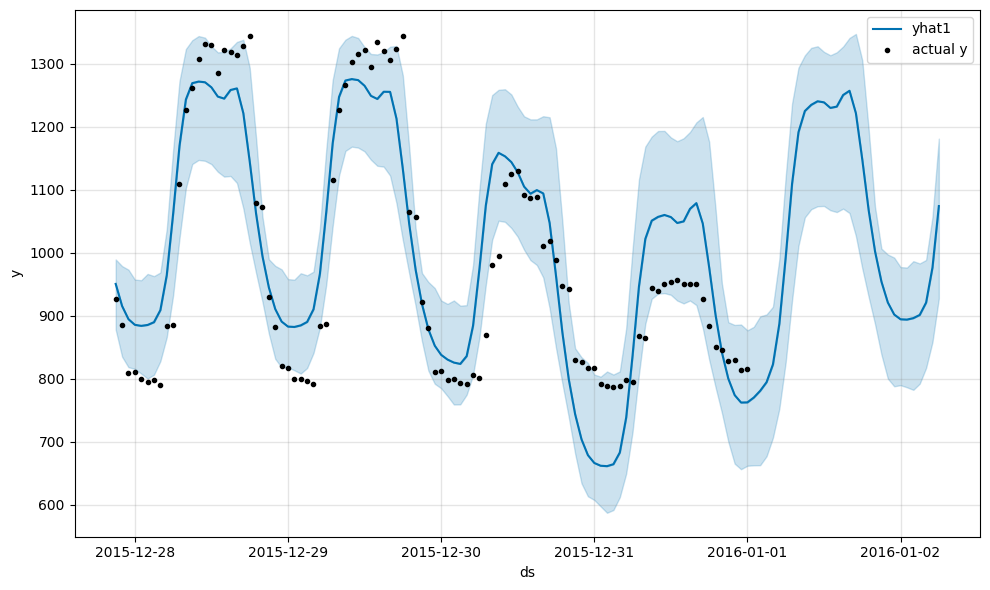

In [7]:
plotting_backend = "default"
fig_forec = qr_model.plot(forecast, plotting_backend=plotting_backend)

### 2. Conformal prediction

While there are different ways to carry out conformal prediction, NeuralProphet adopts the split conformal prediction, which requires a holdout or calibration set. To carry out split conformal prediction, the dataset has to be split into three distinct sets for training, calibration and testing respectively. An initial prediction interval is created with the base model trained by the training dataset. Uncertainty is quantified by comparing the target variables in the calibration set against the predicted value. The final conformal prediction interval is then formed by adding the quantified uncertainty to both tails of the predicted value.

You can select *Naive* (or absolute residual) or *Conformalized Quantile Regression* (or CQR) for the conformal prediction in NeuralProphet. We will be discussing these two option in detail in the following sub-session.

#### Calibration and validation set 
At least three subsets (i.e. testing, calibration and testing) are needed in the conformal prediction feature in NeuralProphet. You may choose to opt in a validation subset in this model. If you want to add in a validation subset to train the base model, please make sure the period of the validation subset must be in between of the training and calibration subsets. We will not cover validation procedure in detail here, you can however refer to the [Train, Validate and Test procedure](https://neuralprophet.com/notebooks/test_and_crossvalidate.html#3.-Advanced:-3-Phase-Train,-Validate-and-Test-procedure) tutorial to know how to build up a NeuralProphet model using validation set.

Here, we further divide the calibation set from the training set with a train-calibration ratio of $1/11$.

In [8]:
# Add calibration set using the data splitting function
train_df, cal_df = m.split_df(train_df, freq="H", valid_p=1.0 / 11)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


After this splitting, we will have 7467, 746 and 547 instances extracted in sequence as training, calibration and testing set respectively.

In [9]:
train_df.shape, cal_df.shape, test_df.shape

((7467, 2), (746, 2), (547, 2))

#### Base model training
You can build any NeuralProphet model you deemed as fit as the base model. The calibration process in conformal prediction would be later added on the base model to quantify the uncertainty in our final estimation.

We are interested to know how conformal prediction affects different models. Back to our example, we will be comparing the conformal prediction results between a simple quantile regression and a complex 4-layer autoregression model in our illustration here. You can refer to the quantile regression session above and the [Autoregression](https://neuralprophet.com/notebooks/autoregression_yosemite_temps.html)  standalone tutorial material for the logic and applications of the features.

In [10]:
# Parameter for autoregression
# Predict the value in the next hours based on the last three daysin an-hour steps
n_lags = 3 * 24

In [11]:
# Create a simple quantile regression model
cp_model1 = NeuralProphet(quantiles=quantile_list)

# Create a 4-layer autoregression model as the base
cp_model2 = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantile_list,
)

After finish configuring the model, we fit the model with the train set. If you have further split the training dataset into training and validation, you can either (i) concatenate the two datasets in one dataset for training or (ii) assign the training and validation datasets as two separated parameters. 

In [12]:
# Feed the training subset in the configured NeuralProphet models
# Configure the hourly frequency by assigning 'H' to parameter freq
set_random_seed(0)
metrics1 = cp_model1.fit(train_df, freq="H")
set_random_seed(0)
metrics2 = cp_model2.fit(train_df, freq="H")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (234) is too small than the required number for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111


Training: 0it [00:00, ?it/s]

We use the fitted base model to forecast both the point prediction and the quantile regression prediction intervals for the testing dataset. 

In [13]:
# Perform estimation for the testing data with the trained model
forecast1 = cp_model1.predict(test_df)[n_lags:]
forecast2 = cp_model2.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


#### Option 1: Naive Conformal Prediction
After training the base model, we then carry out the calibration process using the `naive` module. The steps are outlined as follow:
<br>i. predict the output value of the instances within the calibration set;
<br>ii. calculate absolute residual by comparing the actual and predicted value for each observation in the calibration set;
<br>iii. sort all absolute residual in ascending order; 
<br>iv. finds the quantified uncertainty ($\hat{q}$) with the desired confidence level; and
<br>v. use the quantified uncertainty ($\hat{q}$) to make the final prediciton intervals.

Going back to our example, we need to denote the parameter value for calibration set, significant level (alpha) for conformal prediction on top of the pre-trained models above.

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


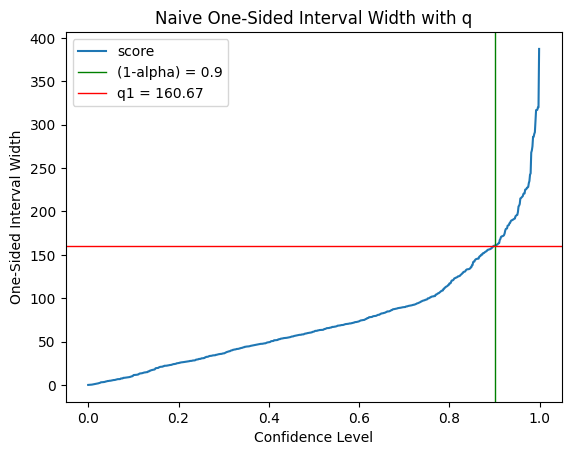

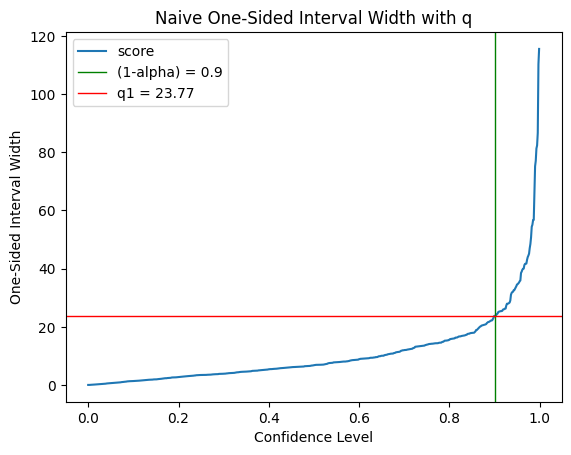

In [14]:
# Parameter for naive conformal prediction
method = "naive"
alpha = 1 - confidence_lv

# Enable conformal predict on the pre-trained models
# Evaluate parameter is optional, refer to the "Evaluate Performance" session below
naive_forecast1 = cp_model1.conformal_predict(
    test_df, calibration_df=cal_df, alpha=alpha, method=method, plotting_backend=plotting_backend
)
naive_forecast2 = cp_model2.conformal_predict(
    test_df, calibration_df=cal_df, alpha=alpha, method=method, plotting_backend=plotting_backend
)

The plots above demonstrate how quantified uncertainty ($\hat{q}$) change with different confidence level (`1-alpha`). 


Below are the $\hat{q}$ values for each model. As they are all positive, you will see the naive interval extending beyond that of simple QR. The weaker model has a large gap between these two intervals since it has a larger $\hat{q}$ value, while the bounds are shifted much less for complex model.

In [15]:
naive_qhat1 = naive_forecast1.iloc[0]["qhat1"]  # cp_model1
naive_qhat2 = naive_forecast2.iloc[0]["qhat1"]  # cp_model2
naive_qhat1, naive_qhat2

(160.67302487812503, 23.765111793749952)

We can then plot the predicted intervals (5th, 50th and 95th percentile values) to compare the performance of the models. The quantile regression prediction intervals are annoted in blue while the conformal prediction intervals with the quantified uncertainty included are denoted in red.

With the same quantile parameter, the simple model has a much wider quantile regression prediction interval (in blue) comparing to the complex model. The same happens to the conformal prediction intervals (in red), where the weaker model has a wider width as such it can capture more more actual values than the quantile regression prediction intervals. 

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


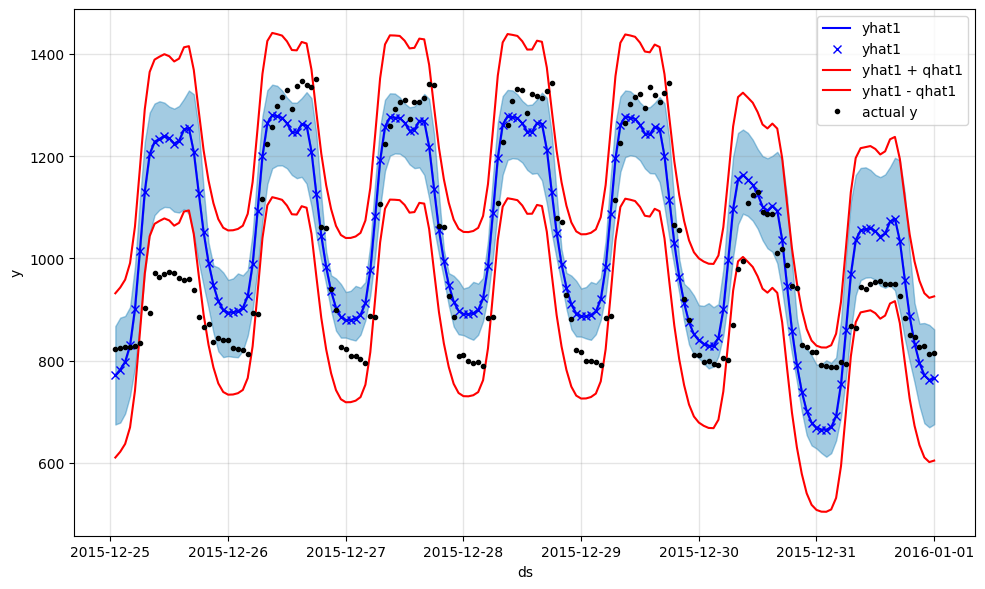

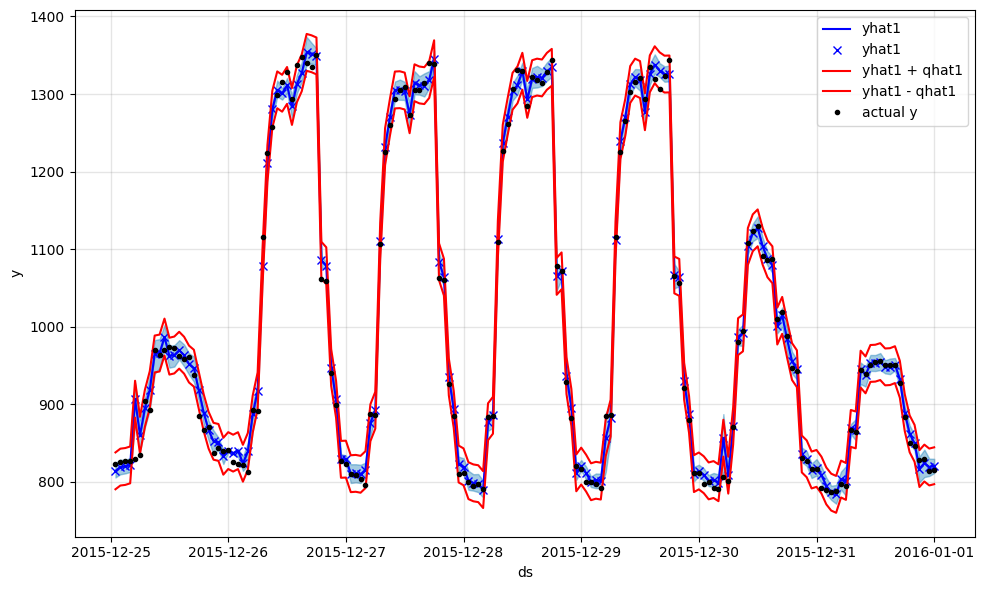

In [16]:
# Date range shown in the plots (optional)
cutoff = 7 * 24

fig1 = cp_model1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast1[-cutoff:], plotting_backend=plotting_backend
)
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast2[-cutoff:], plotting_backend=plotting_backend
)

#### Option 2: Conformalized Quantile Regression
In [Conformalized Quantile Regression](https://arxiv.org/abs/1905.03222), or the `cqr` module, the method runs as follows:
<br>i. calculate non-conformity scores as the differences between data points from the calibration dataset and their nearest prediction quantile, which provides a measure of how well the data fits the current quantile regression model. The non-conformity scores are negative for data points within the quantile regression interval and positive if they are outside the interval;
<br>ii. sort list of non-conformity scores;
<br>iii. find the value of $\hat{q}$ such that the portion of scores in the list greater than $\hat{q}$ is equal to that error rate; and
<br>iv. adjust the quantiles from the regression model by an amount ($\hat{q}$).

There are two scenarios for what the CQR model means based on the value of $\hat{q}$. If the one-sided prediction interval width adjustment is **positive**, then CQR extends beyond the QR intervals, as it deems the QR interval to be too **confident**. Conversely, if the one-sided prediction interval width adjustment is **negative**, then CQR contracts the QR intervals, as it deems the QR interval to be too **conservative**.


In [17]:
# Parameter for Conformalized Quantile Regression
method = "cqr"

# Enable conformal predict on the pre-trained models
# Evaluate parameter is optional, refer to the "Evaluate Performance" session below
cqr_forecast1 = cp_model1.conformal_predict(
    test_df, calibration_df=cal_df, alpha=alpha, method=method, plotting_backend=plotting_backend
)
cqr_forecast2 = cp_model2.conformal_predict(
    test_df, calibration_df=cal_df, alpha=alpha, method=method, plotting_backend=plotting_backend
)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


KeyError: 'yhat1 4.999999999999999%'

Below are the $\hat{q}$ values for each model. As they are all positive, you will see the CQR interval extending beyond that of simple QR. cp_model1 has a large gap between these two intervals since it has a larger $\hat{q}$ value, while the bounds are shifted much less for cp_model2.

In [ ]:
cqr_qhat1 = cqr_forecast1.iloc[0]["qhat1"]  # cp_model1
cqr_qhat2 = cqr_forecast2.iloc[0]["qhat1"]  # cp_model2

cqr_qhat1, cqr_qhat2

We again plot the prediction intervals to examine how this CQR method affects the result. 

In [ ]:
fig1 = cp_model1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], plotting_backend=plotting_backend
)
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], plotting_backend=plotting_backend
)

### Evaluate Performance

We are using interval width and miscoverage rate as the performance metrics.
- `interval_width`: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive, this is also knowns as the *efficiency* metric.
- `miscoverage_rate`: The actual miscoverage error rate on the OOS test set, this is also knowns as the *validity* metric.

The smaller the metrics are, the better the models are performing.

Let's test with the models we trained above. We first build a dataframe with two rows for the two models we trained and then we will concatenate the Naive and CQR performance metrics in the dataframe for the evaluation.

In [ ]:
# Create evaluation dataframe skeleton with the 2 models (denoted as m1 and m2)
models = ["cp_model1", "cp_model1"]
eval_df = pd.DataFrame(models, columns=pd.MultiIndex.from_tuples([("model", "", "")]))

We are aggregating the performance metrics for naive and put them in the evaluation dataframe skeleton at this session. The performance metrics are calculated when you have turned on the `evaluate` parameter in the conformal prediction feature.

In [ ]:
# Extract the naive performance metrics from their respective forecast datasets
naive_eval1 = uncertainty_evaluate(naive_forecast1)
naive_eval2 = uncertainty_evaluate(naive_forecast2)

# Aggregate the naive performance metrics for m1 and m2
naive_evals = [naive_eval1, naive_eval2]
naive_eval_df = pd.concat(naive_evals).reset_index(drop=True)

In [ ]:
# Extract the cqr performance metrics from their respective forecast datasets
cqr_eval1 = uncertainty_evaluate(cqr_forecast1)
cqr_eval2 = uncertainty_evaluate(cqr_forecast2)

# Aggregate the cqr performance metrics for m1 and m2
cqr_evals = [cqr_eval1, cqr_eval2]
cqr_eval_df = pd.concat(cqr_evals).reset_index(drop=True)

Lastly, we concatenate the naive and cqr evaluation dataframes and then compare how the models are performing with the naive and cqr prediction.

In [ ]:
# Drop QR from CQR evaluation results as it already exists in Naive
cqr_eval_df = cqr_eval_df.drop("qr", axis=1, level=1)

# Concatenate the naive and cqr evaluation dataframes
eval_df = pd.concat([eval_df, naive_eval_df, cqr_eval_df], axis=1)
eval_df

**Performance of the trained model above**:

- This notebook is only using single forecast timestep models, hence we would only have `yhat1` as the point estimator.
- Both conformal prediction methods (*Naive* and *CQR*), significantly outperforms vanilla *QR* in terms of `miscoverage_rate`. This shows that the *QR* is **too overconfident** in its quantile values. Hence the `interval_width` needs to be **broadened further** in order for its actual `miscoverage_rate` (on out-of-sample test set) to converge to the specified `alpha` at `0.1` (from calibration set).
- The `interval_width` doubles the quantified uncertainties (`qhat1`) for both the *Naive* conformal predictions, as such you will be seeing symmetrical prediction intervals.
- The complex model (`m2`) has a lower `interval_width` and `miscoverage_rate` than the simple model (`m1`), acroos all uncertainty methods. The simpler model (`m1`) have `miscoverage_rate` bigger than the confidence level (i.e., 90% or `1-alpha`) while the complex autoregressioin model (`m2`) have a `miscoverage_rate` smaller than the confidence level. As such, we can conclude that **the more complex the model is, the better the data are fitted and the more accurate the prediction are made**.
- When we are only looking at the simple quantile regression model (`m1`), *CQR* is more preferable as it has narrower prediction `interval_width` yet similar `miscoverage_rate` than *Naive*.
- As for the complex model (`m2`), *Naive* has a slightly better `interval_width`, but *CQR* has a slightly better `miscoverage_rate`. You may want to feed the model with more data to determine which method more preferable.
